# Parameter Settings

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils
from train import VariationalAutoencoder


In [4]:
vae = VariationalAutoencoder()
vae.load_state_dict(torch.load('./checkpoints/1118-224553/my_vae.pth'))
vae.eval()

VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=8192, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=8192, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=8192, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

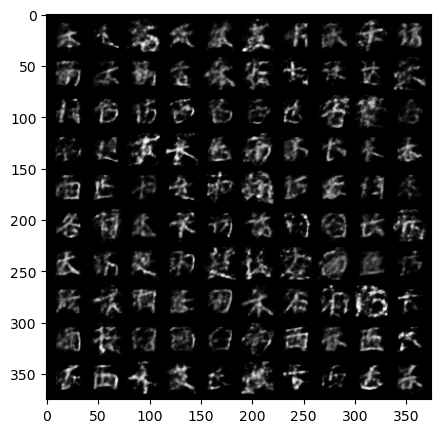

In [22]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

Show 2D Latent Space
---------------------

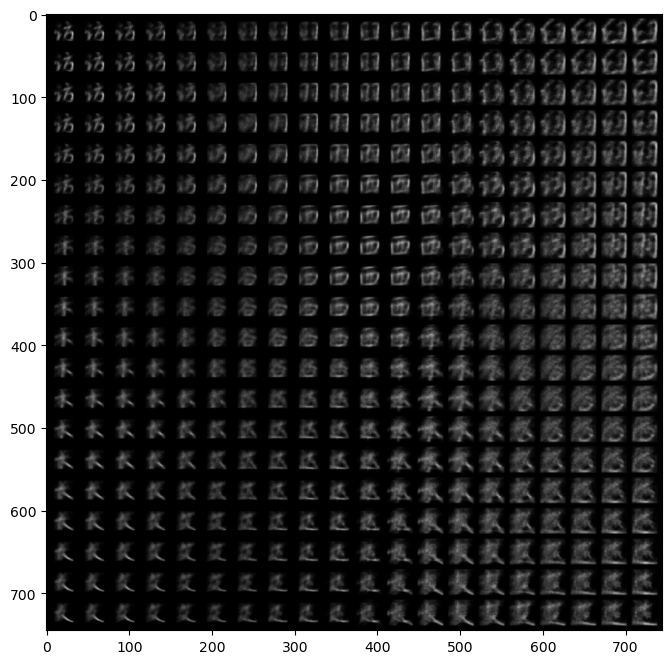

In [9]:
# load a network that was trained with a 2d latent space
# if latent_dims != 2:
#     print('Please change the parameters to two latent dimensions.')
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))




with torch.no_grad():

    latent_dim = 2

    # create a sample grid for the first two dimensions in 12d latent space
    latent_x = np.linspace(-1.5, 1.5, 20)
    latent_y = np.linspace(-1.5, 1.5, 20)

    # 初始化一个全零的张量，大小为 (20, 20, 12)
    latents = torch.zeros(len(latent_y), len(latent_x), latent_dim)

    # 遍历生成的x和y，将它们分别放到12维隐变量的前两个维度
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx  # 第一个维度为lx
            latents[j, i, 1] = ly  # 第二个维度为ly

    # 将形状改为 (400, 12)，即20x20的网格展平成400个样本，每个样本12维
    latents = latents.view(-1, latent_dim)

    

    # 使用VAE的解码器从隐变量中重建图像
    image_recon = vae.decoder(latents)

    # 将重建的图像移回CPU以便显示
    image_recon = image_recon.cpu()

    # 可视化生成的图像，构造 20x20 的网格
    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(image_recon.data[:400], nrow=20, padding=5))
    plt.show()

# 拆分

In [ ]:
import os
from PIL import Image
import torchvision

# 创建输出文件夹
output_dir = 'latent_space_images'
os.makedirs(output_dir, exist_ok=True)

# 检查潜在空间的维度是否为2
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

import torch
import numpy as np
import torchvision
import os

# 假设 vae 和 device 已经定义好了
with torch.no_grad():
    np.random.seed(42)
    # 使用随机抽样生成潜在空间的点
    num_samples = 1600  # 生成 1600 个随机点
    latent_x = np.random.uniform(-1.5, 1.5, num_samples)
    latent_y = np.random.uniform(-1.5, 1.5, num_samples)
    
    # 创建一个 (1600, 2) 的张量，其中每一行是一个 (latent_x, latent_y) 对
    latents = torch.FloatTensor(num_samples, 2)
    
    # 填充潜在空间的点
    latents[:, 0] = torch.tensor(latent_x)
    latents[:, 1] = torch.tensor(latent_y)
    
    # 将张量传输到设备 (如 GPU)
    latents = latents

    # 使用解码器重建图像
    image_recon = vae.decoder(latents)

    # 假设生成的图像大小为 (N, C, H, W)
    N, C, H, W = image_recon.shape

    # 使用 PIL 保存每个图像
    for idx in range(N):
        # 获取当前图像的随机坐标
        x_coord = latent_x[idx]
        y_coord = latent_y[idx]

        # 取出图像并转换为 PIL 图像
        img_tensor = image_recon[idx]
        img_pil = torchvision.transforms.ToPILImage()(img_tensor)

        # 定义文件名，文件名格式为 "x_y.png"
        filename = f"{x_coord:.2f}_{y_coord:.2f}.png"
        img_path = os.path.join(output_dir, filename)

        # 保存图像
        img_pil.save(img_path)

    print(f"Images saved to {output_dir}")

Images saved to latent_space_images
